In [1]:
cd ..

/lustre/groups/ml01/workspace/carlo.dedonno/scarches_repo/scarches


In [2]:
import os
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

from scarches.dataset.trvae.data_handling import remove_sparsity
from scarches.models.scpoli import scPoli

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

/lustre/groups/ml01/workspace/carlo.dedonno/scarches_repo/scarches/scarches/dataset/__init__.py:9: UserWarning: In order to use the mouse gastrulation seqFISH datsets, please install squidpy (see https://github.com/scverse/squidpy).
  warnings.warn('In order to use the mouse gastrulation seqFISH datsets, please install squidpy (see https://github.com/scverse/squidpy).')
/lustre/groups/ml01/workspace/carlo.dedonno/scarches_repo/scarches/scarches/models/__init__.py:11: UserWarning: In order to use sagenet models, please install pytorch geometric (see https://pytorch-geometric.readthedocs.io) and 
 captum (see https://github.com/pytorch/captum).
  warnings.warn('In order to use sagenet models, please install pytorch geometric (see https://pytorch-geometric.readthedocs.io) and \n captum (see https://github.com/pytorch/captum).')
Global seed set to 0
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationW

In [5]:
adata = sc.read('../../lataq_reproduce/data/pancreas.h5ad')
adata

AnnData object with n_obs × n_vars = 16382 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    obsm: 'X_seurat', 'X_symphony'

In [6]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


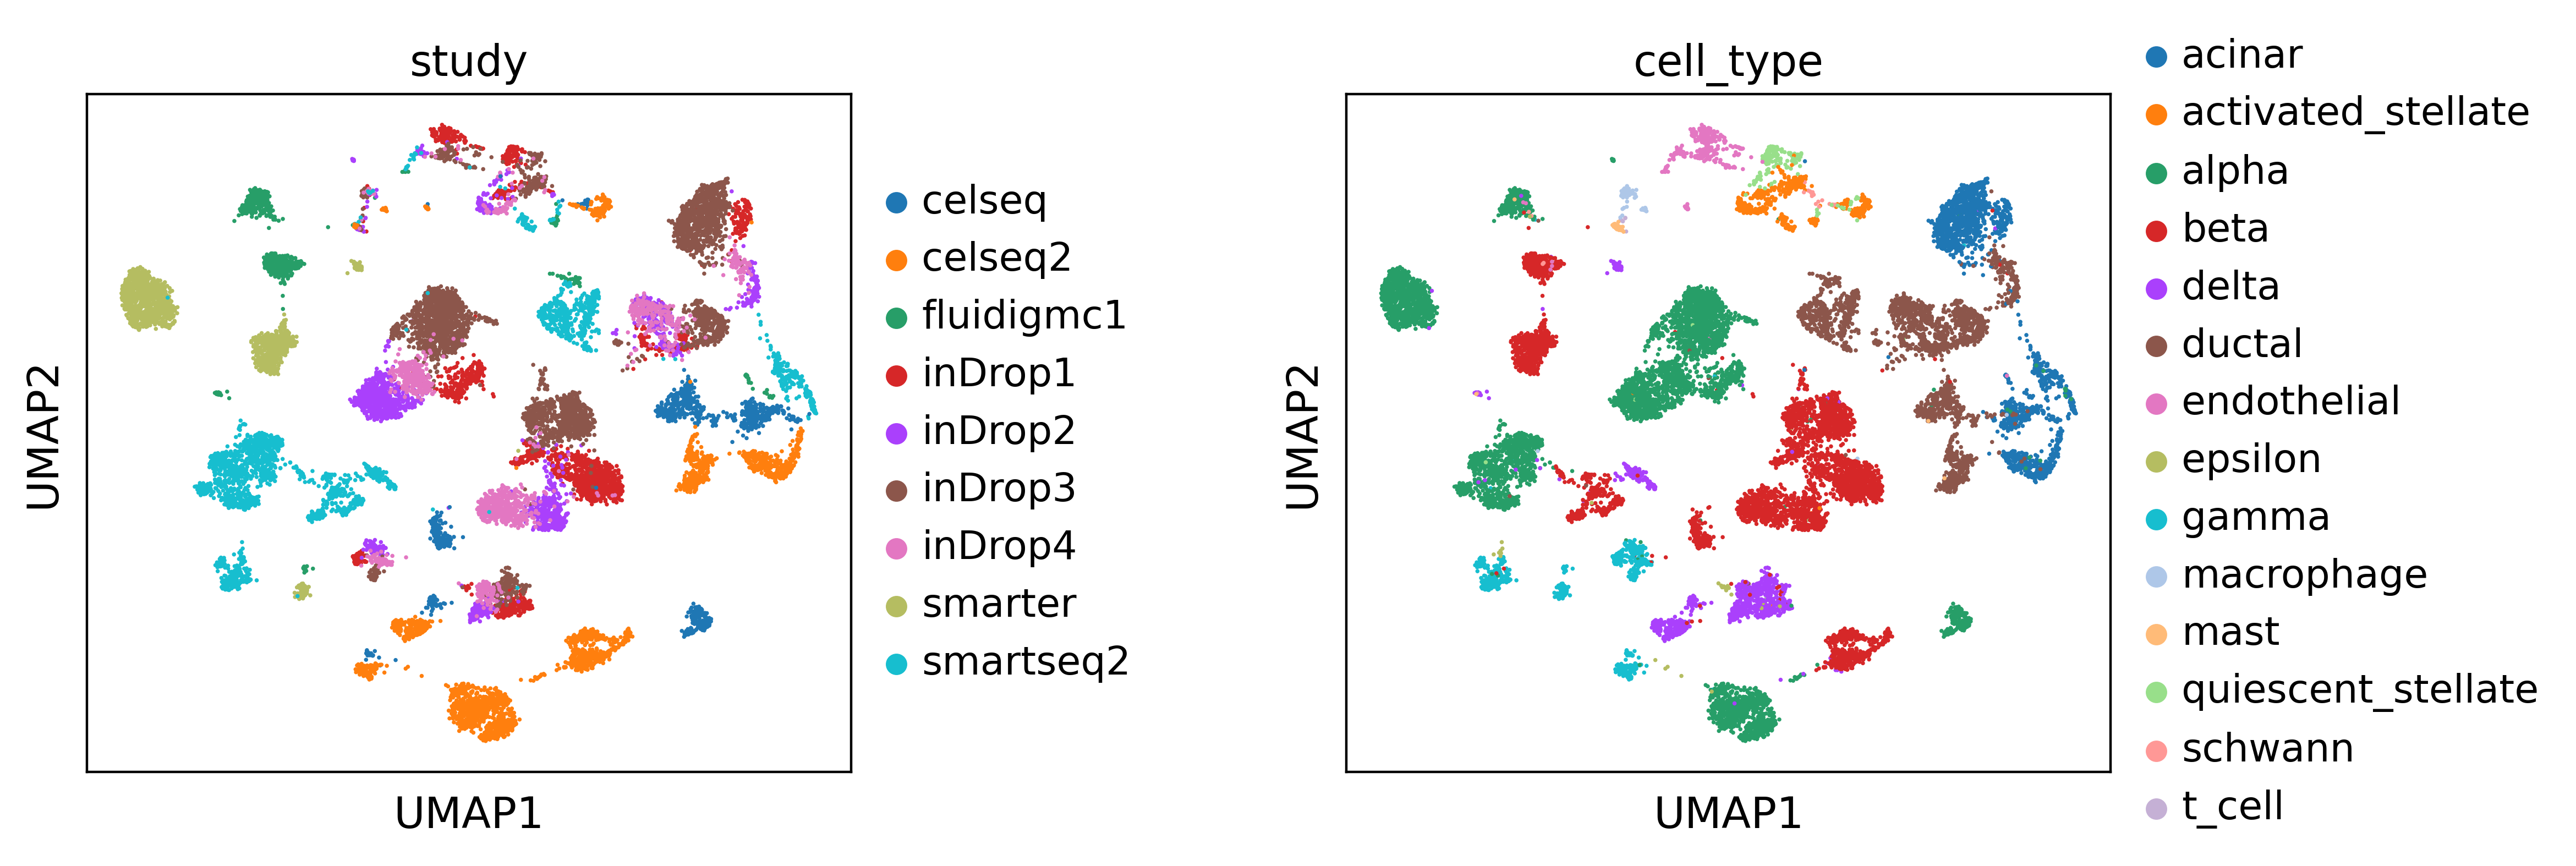

In [7]:
sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.5)

In [8]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_landmark_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

condition_key = 'study'
cell_type_key = ['cell_type']
reference = ['inDrop1', 'inDrop2', 'inDrop3', 'inDrop4', 'fluidigmc1', 'smartseq2', 'smarter']
query = ['celseq', 'celseq2']

In [9]:
adata.obs['query'] = adata.obs[condition_key].isin(query)
adata.obs['query'] = adata.obs['query'].astype('category')
source_adata = adata[adata.obs.study.isin(reference)].copy()
target_adata = adata[adata.obs.study.isin(query)].copy()

In [10]:
source_adata, target_adata

(AnnData object with n_obs × n_vars = 13093 × 4000
     obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'query'
     uns: 'neighbors', 'umap', 'study_colors', 'cell_type_colors'
     obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 3289 × 4000
     obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'query'
     uns: 'neighbors', 'umap', 'study_colors', 'cell_type_colors'
     obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
     obsp: 'distances', 'connectivities')

In [11]:
scpoli_model = scPoli(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
)

Embedding dictionary:
 	Num conditions: 7
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 256 10
	Hidden Layer 1 in/out: 256 64
	Mean/Var Layer in/out: 64 10
Decoder Architecture:
	First Layer in, out and cond:  10 64 10
	Hidden Layer 1 in/out: 64 256
	Output Layer in/out:  256 4000 



In [16]:
scpoli_model.train(
    n_epochs=10,
    pretraining_epochs=5,
    early_stopping_kwargs=early_stopping_kwargs,
)

 |████████████████████| 100.0%  - val_loss: 1035.2082353072 - val_trvae_loss: 1030.5901877663 - val_landmark_loss: 4.6180439646 - val_labeled_loss: 4.6180439646
Saving best state of network...
Best State was in Epoch 9


In [9]:
scpoli_model.save('pancreas/', overwrite=True)

In [17]:
scpoli_query = scPoli.load_query_data(
    adata=target_adata,
    reference_model=scpoli_model,
    labeled_indices=[],
)

Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 256 10
	Hidden Layer 1 in/out: 256 64
	Mean/Var Layer in/out: 64 10
Decoder Architecture:
	First Layer in, out and cond:  10 64 10
	Hidden Layer 1 in/out: 64 256
	Output Layer in/out:  256 4000 

9


In [18]:
scpoli_query.train(
    n_epochs=10,
    pretraining_epochs=5,
)

 |██████████----------| 50.0%  - val_loss: 1989.5865071615 - val_trvae_loss: 1989.5865071615
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 9 clusters.
 |████████████████████| 100.0%  - val_loss: 1974.9019775391 - val_trvae_loss: 1974.8979899089 - val_landmark_loss: 0.0040274546 - val_unlabeled_loss: 4.0274542967
Saving best state of network...
Best State was in Epoch 9


In [12]:
scpoli_query.save('pancreas_wquery/', overwrite=True)

In [22]:
results_dict = scpoli_query.classify(
    target_adata.X, 
    target_adata.obs[condition_key], 
)

In [23]:
for i in range(len(cell_type_key)):
    preds = results_dict[cell_type_key[i]]["preds"]
    results_dict[cell_type_key[i]]["probs"]
    classification_df = pd.DataFrame(
        classification_report(
            y_true=target_adata.obs[cell_type_key[i]],
            y_pred=preds,
            output_dict=True,
        )
    ).transpose()

In [24]:
print(classification_df)

                    precision    recall  f1-score      support
acinar               0.941973  0.970120  0.955839   502.000000
activated_stellate   0.929825  0.972477  0.950673   109.000000
alpha                0.998020  0.974855  0.986301  1034.000000
beta                 0.973813  0.981848  0.977814   606.000000
delta                0.968000  0.956522  0.962227   253.000000
ductal               0.965577  0.958974  0.962264   585.000000
endothelial          1.000000  1.000000  1.000000    26.000000
epsilon              0.250000  1.000000  0.400000     5.000000
gamma                1.000000  0.898438  0.946502   128.000000
macrophage           0.916667  0.687500  0.785714    16.000000
mast                 0.500000  0.428571  0.461538     7.000000
quiescent_stellate   0.785714  0.846154  0.814815    13.000000
schwann              0.500000  0.800000  0.615385     5.000000
t_cell               0.000000  0.000000  0.000000     0.000000
accuracy             0.965035  0.965035  0.965035     0

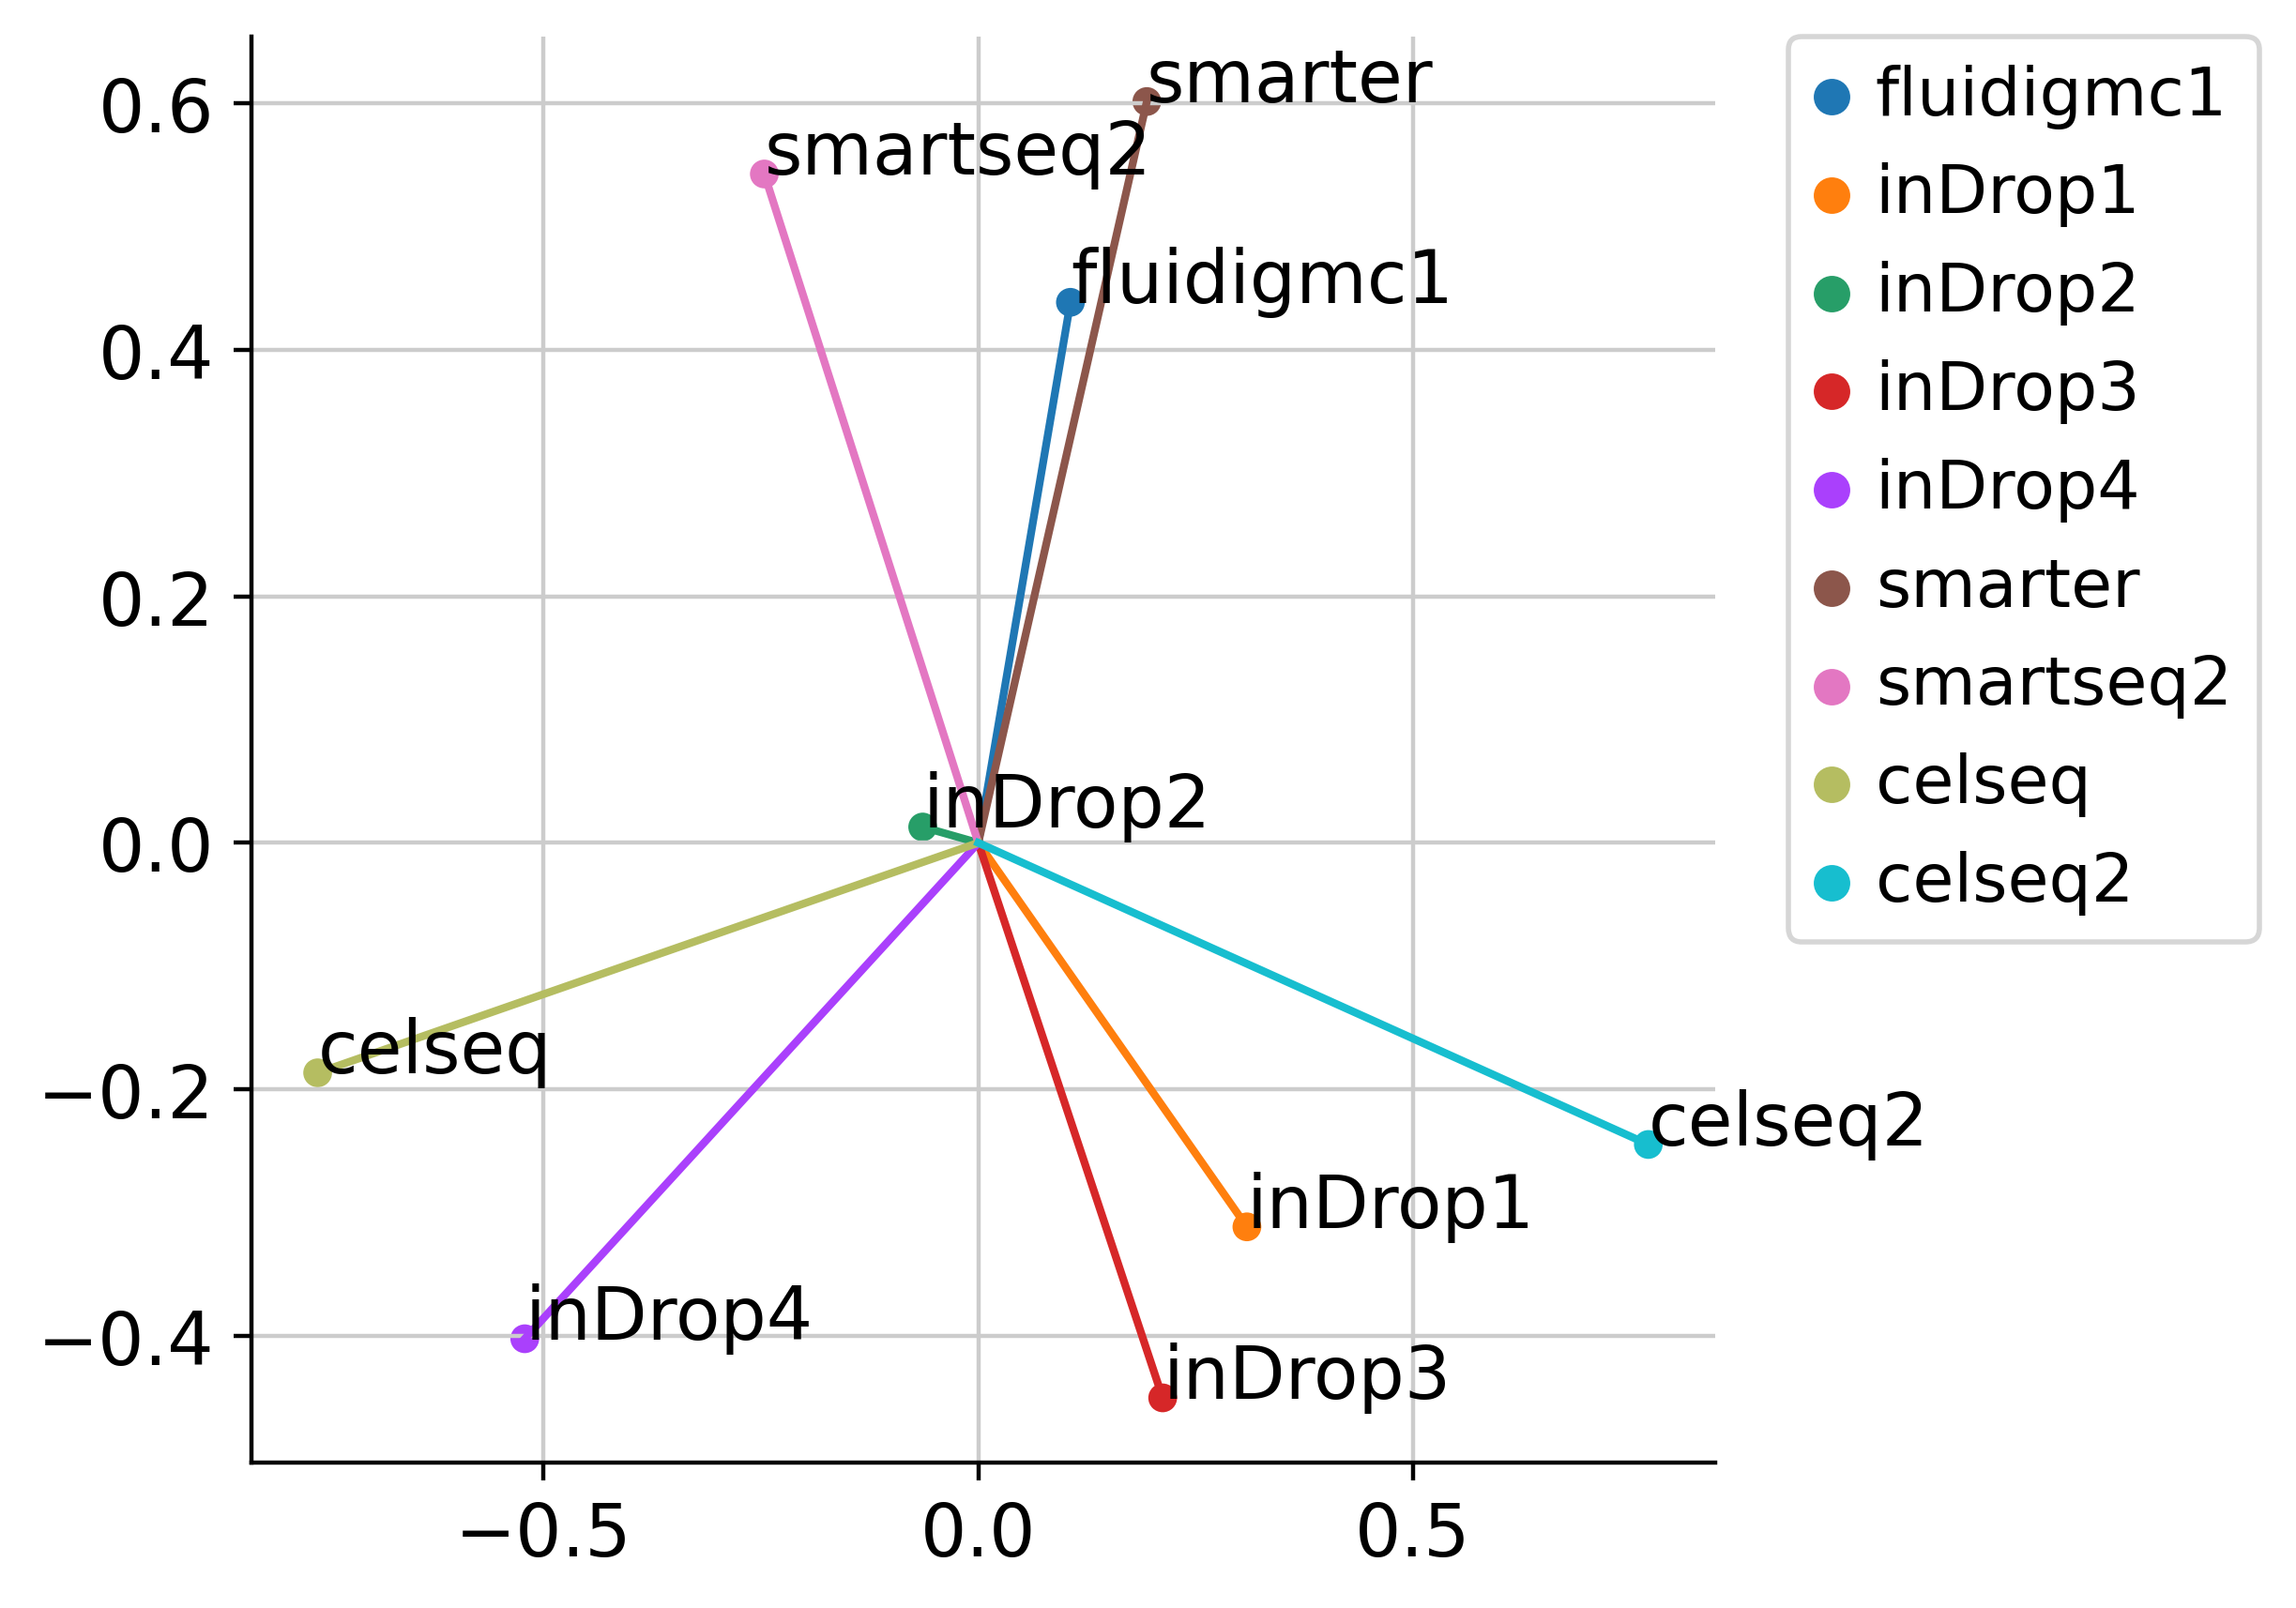

In [34]:
embedding = scpoli_query.model.embedding.weight.detach().cpu().numpy()
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
conditions = scpoli_query.conditions_
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=emb_pca[:, 0], y=emb_pca[:, 1], hue=conditions, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, c in enumerate(conditions):
    ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

[Text(0, 0.5, 'fluidigmc1'),
 Text(0, 1.5, 'inDrop1'),
 Text(0, 2.5, 'inDrop2'),
 Text(0, 3.5, 'inDrop3'),
 Text(0, 4.5, 'inDrop4'),
 Text(0, 5.5, 'smarter'),
 Text(0, 6.5, 'smartseq2'),
 Text(0, 7.5, 'celseq'),
 Text(0, 8.5, 'celseq2')]

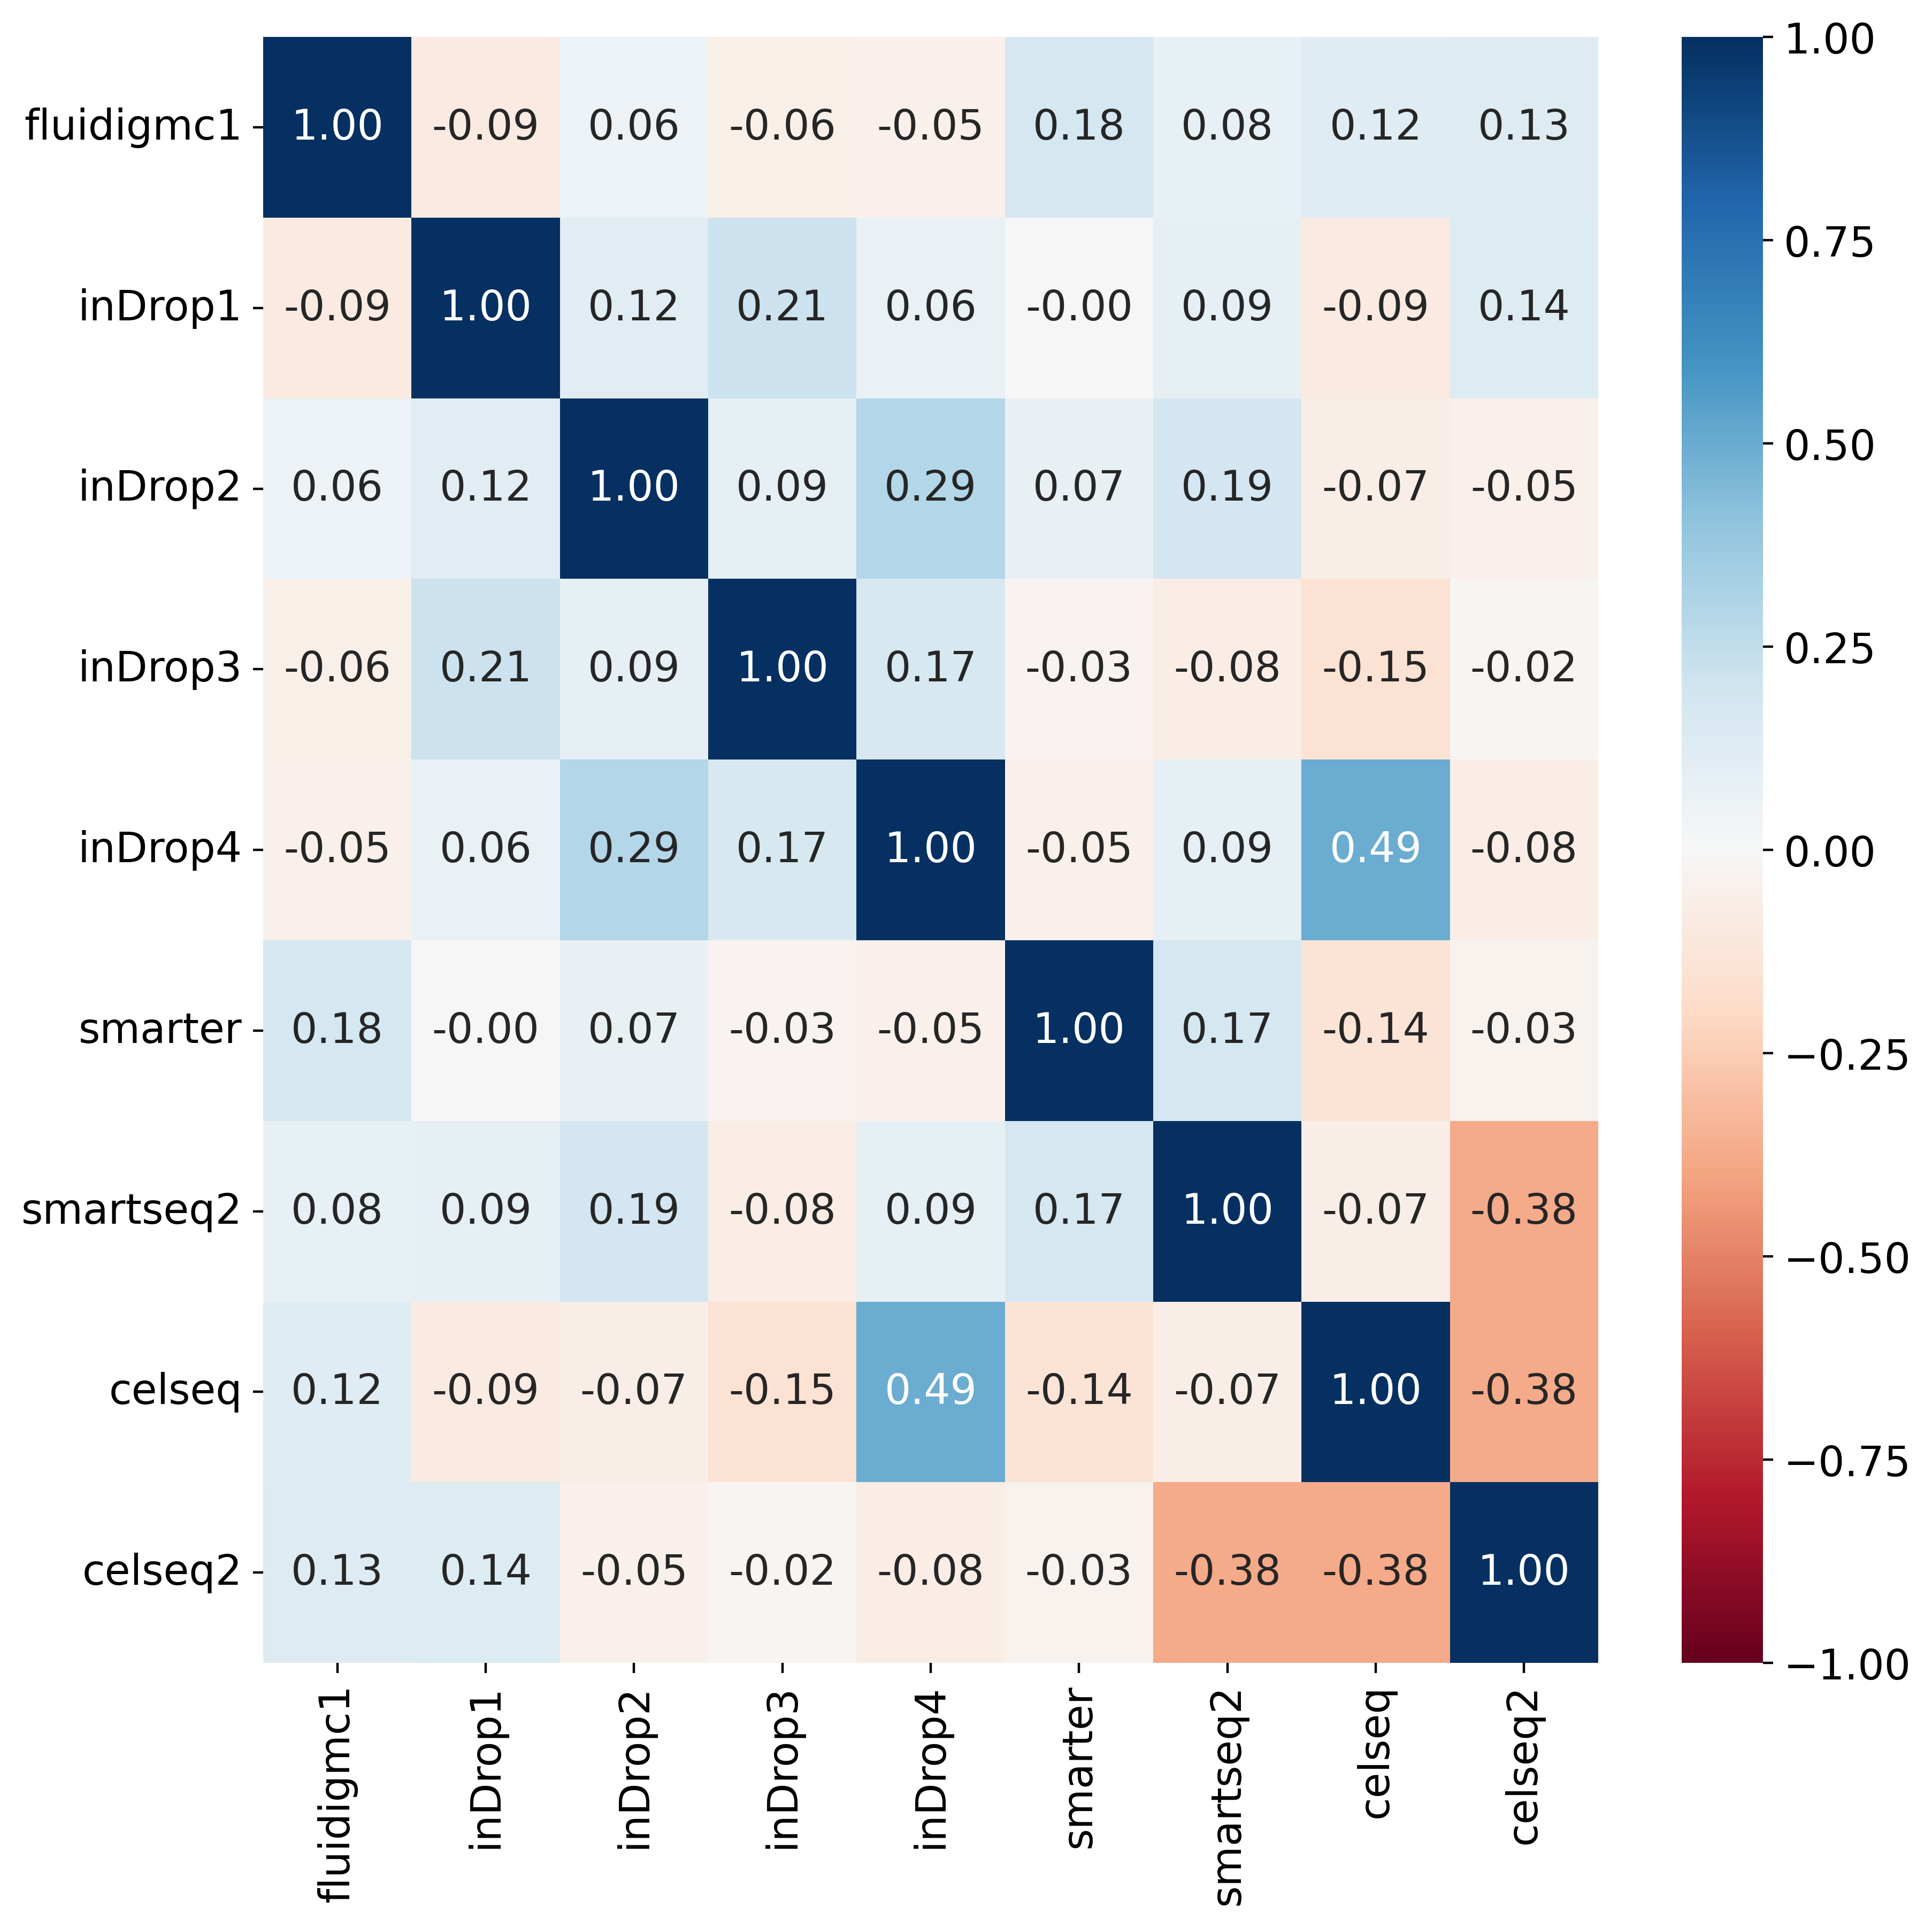

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    cosine_similarity(embedding), 
    cmap='RdBu', 
    annot=True, 
    fmt='.2f',
    ax=ax,
    vmin=-1,
    vmax=1,
)
ax.set_xticklabels(scpoli_query.conditions_, rotation=90)
ax.set_yticklabels(scpoli_query.conditions_, rotation=0)

In [36]:
data_latent = scpoli_query.get_latent(
    adata.X, 
    adata.obs[condition_key].values
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs['batch'] = adata.obs[condition_key].tolist()
results_dict = scpoli_query.classify(
    adata.X, 
    adata.obs[condition_key], 
)
adata.obs['preds'] = results_dict['cell_type']['preds']
adata.obs['uncertainty'] = results_dict['cell_type']['probs']

adata_latent.obs = adata.obs
checks = np.array(len(adata) * ["incorrect"])
checks[adata.obs['preds'] == adata.obs[cell_type_key[0]]] = "correct"
adata_latent.obs['clf_correct'] = checks

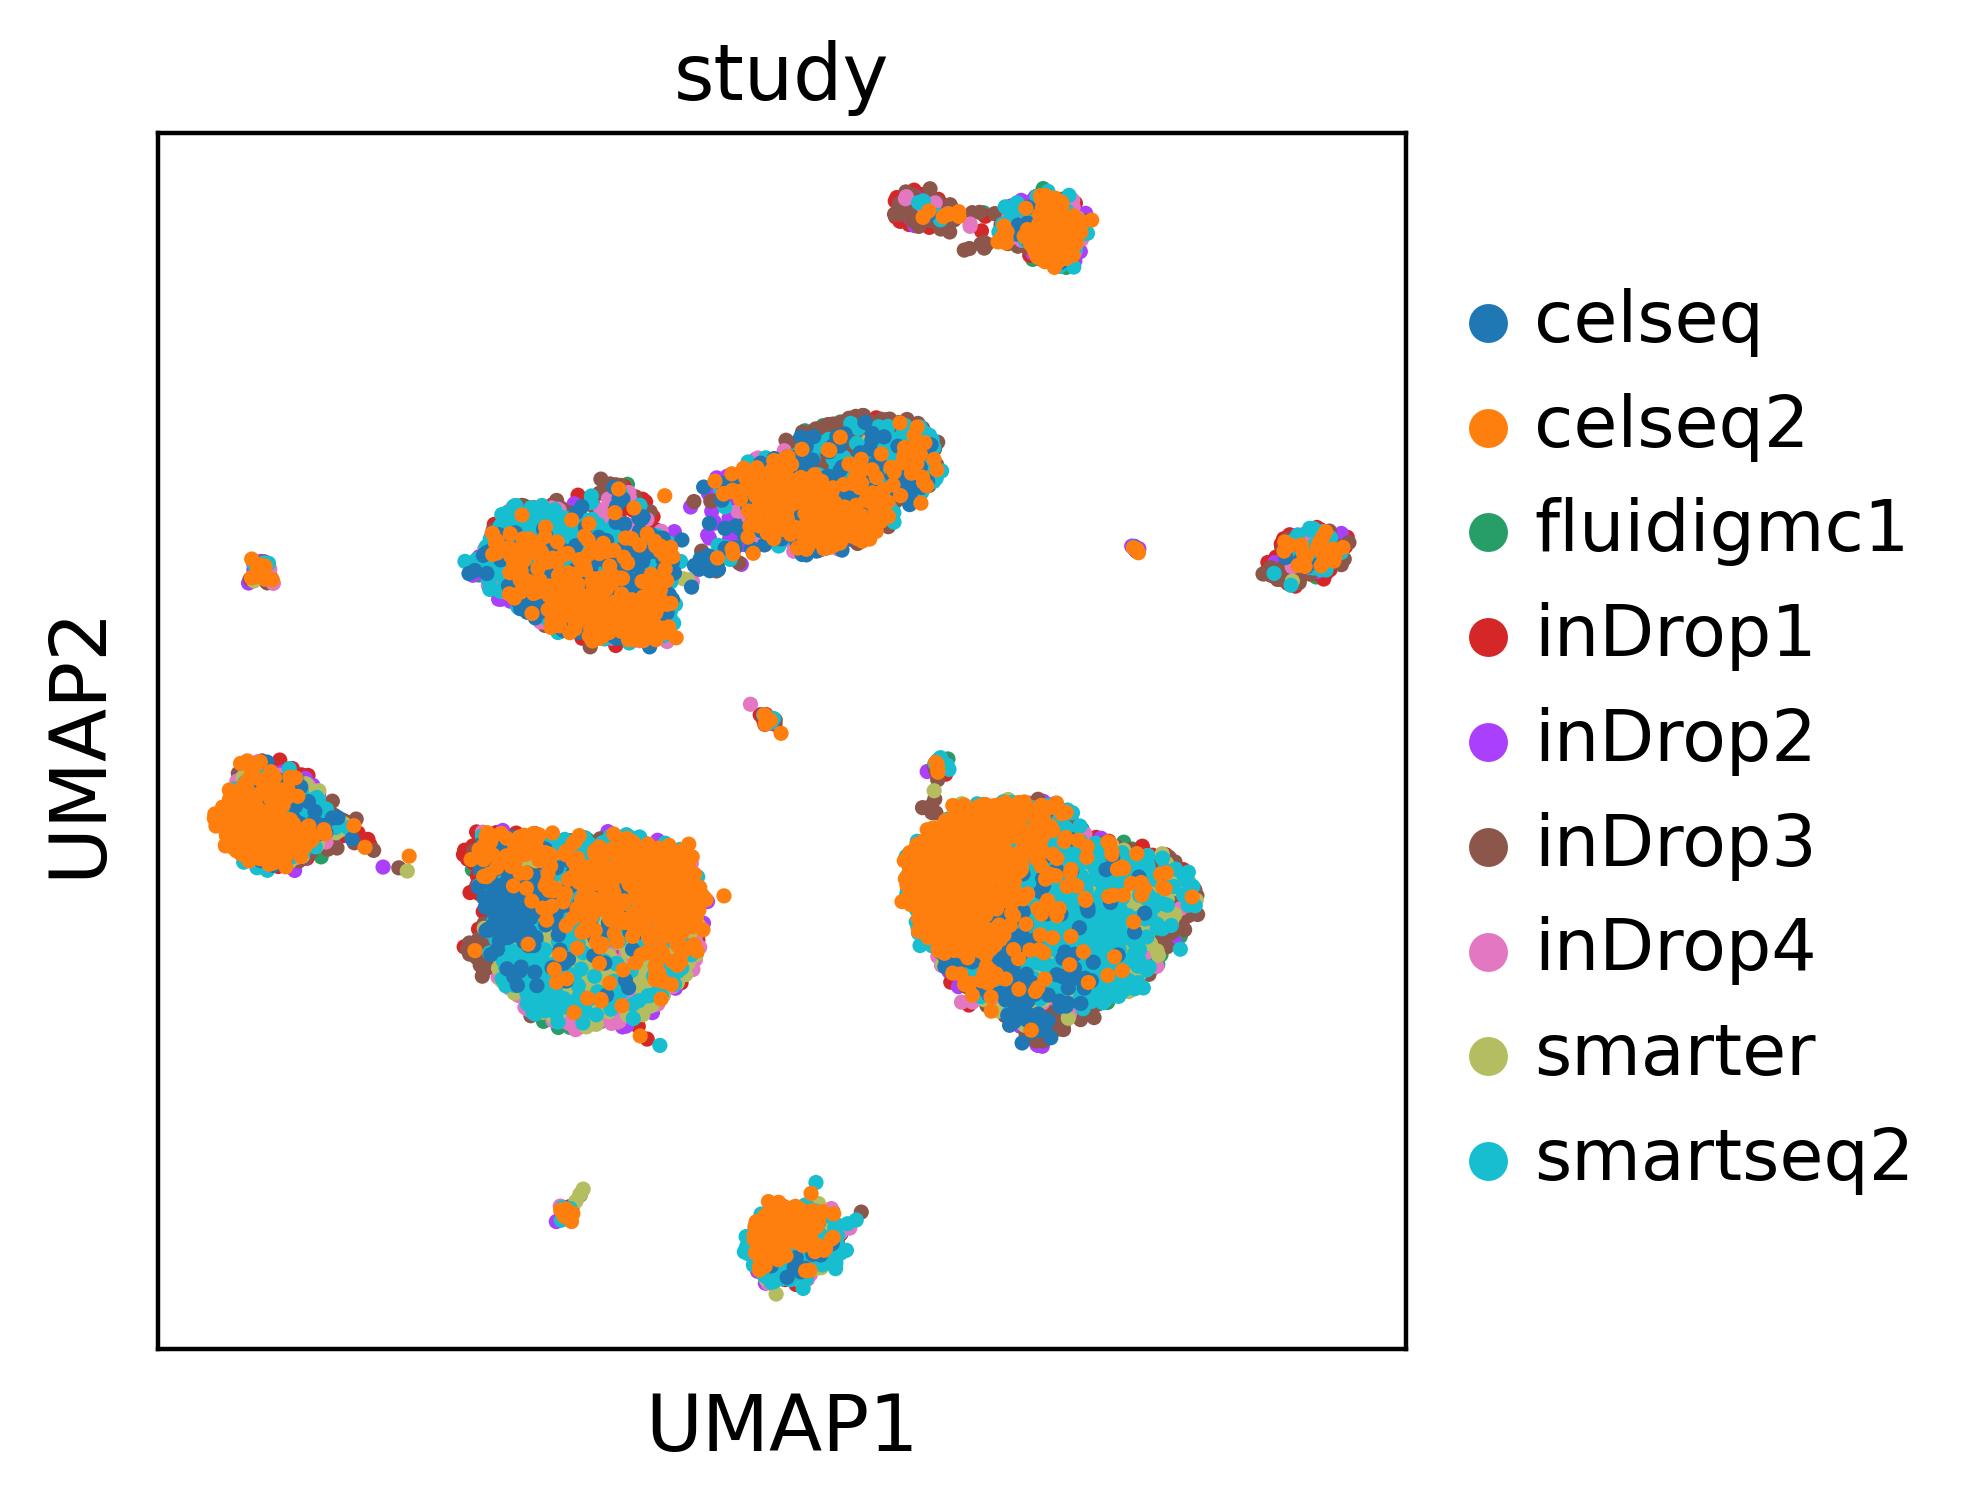

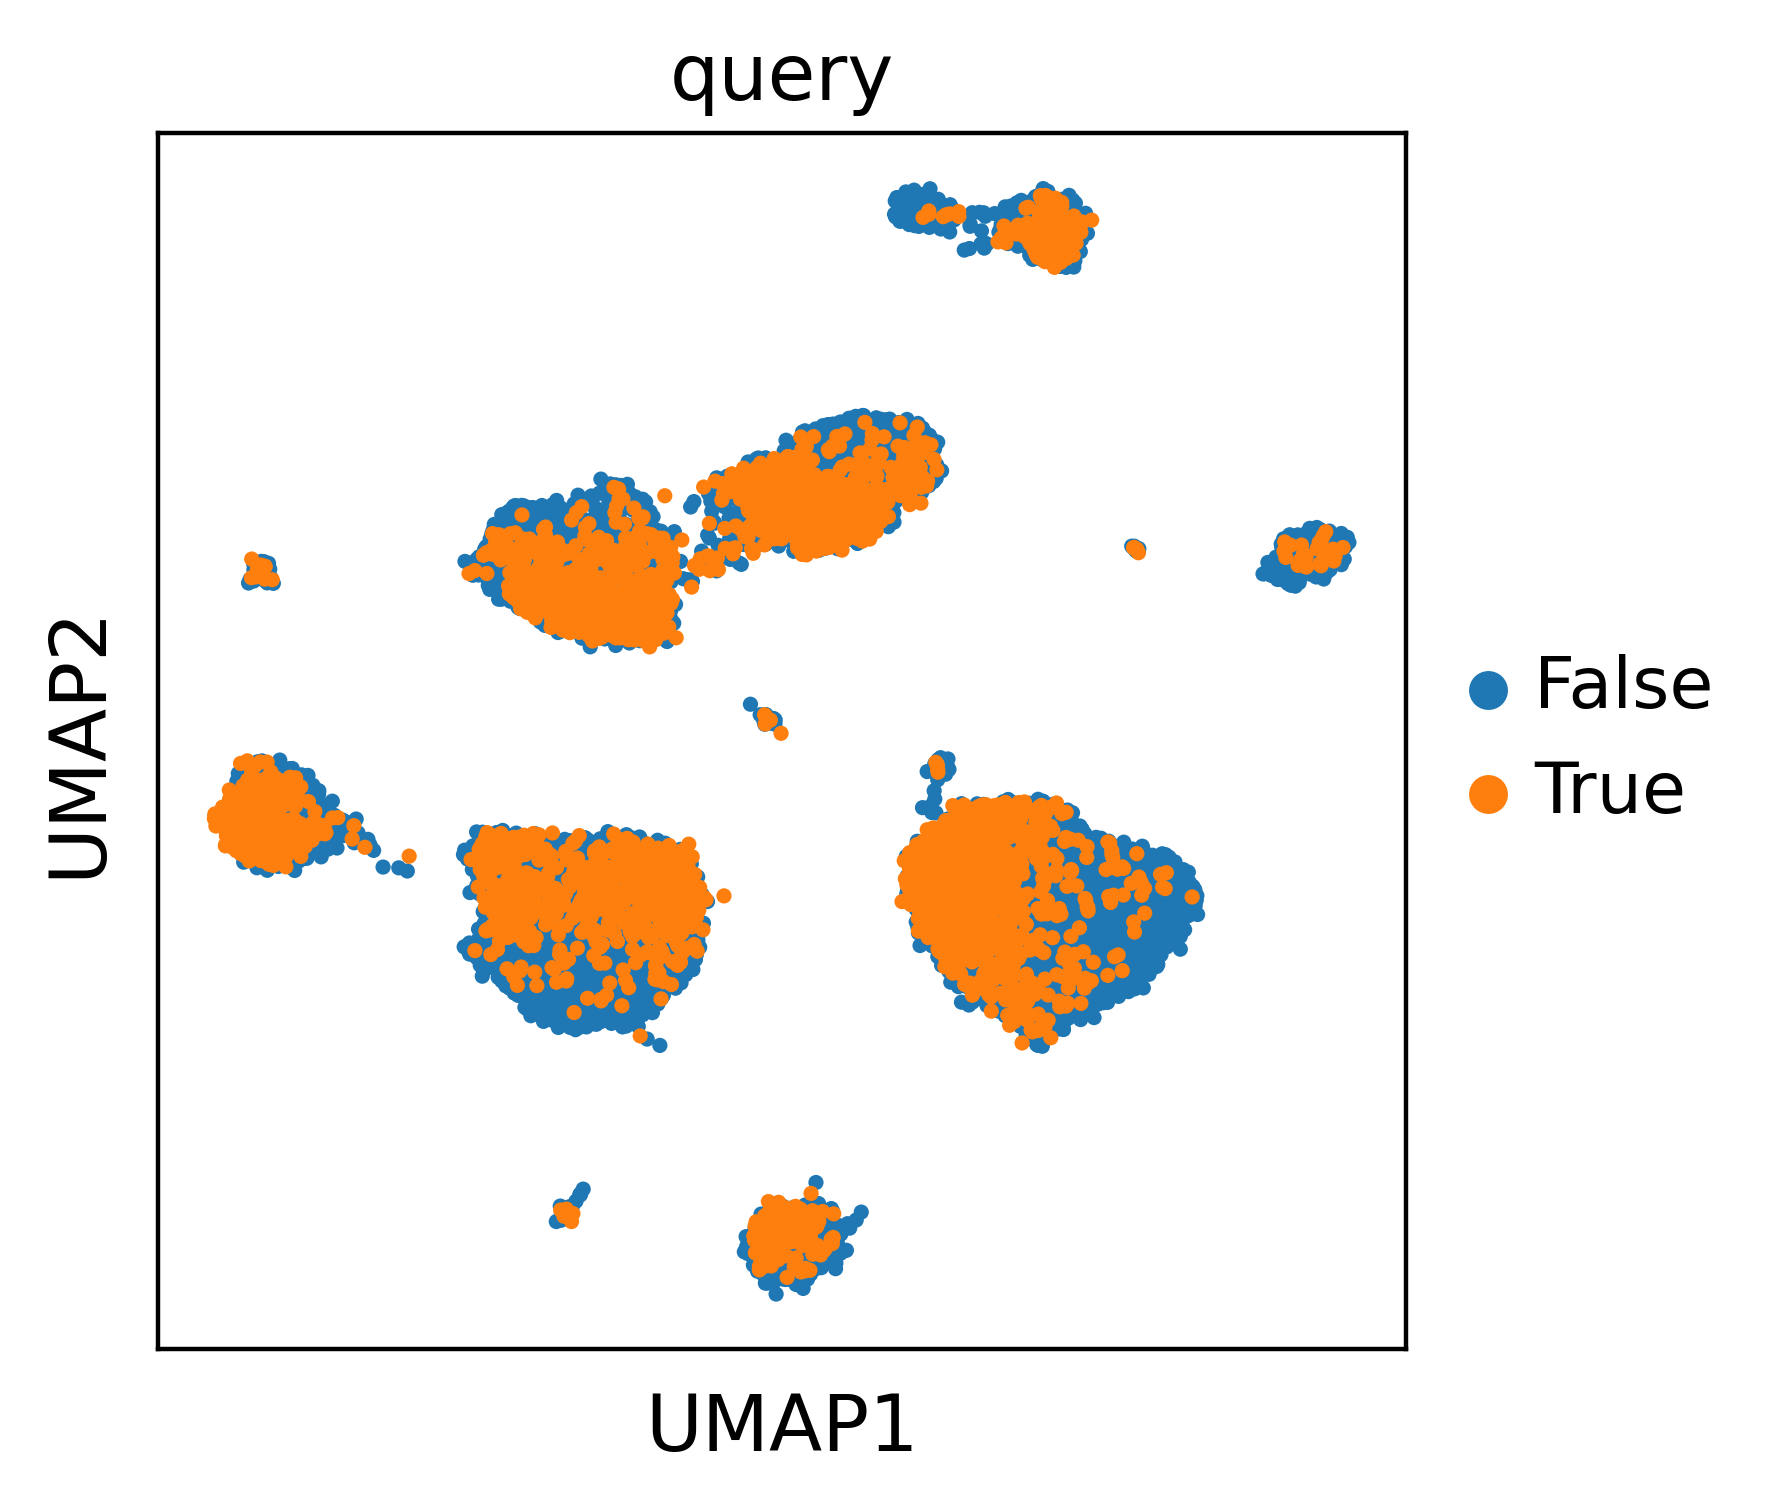

In [37]:
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color=condition_key, size=30)
sc.pl.umap(adata_latent, color='query', size=30)

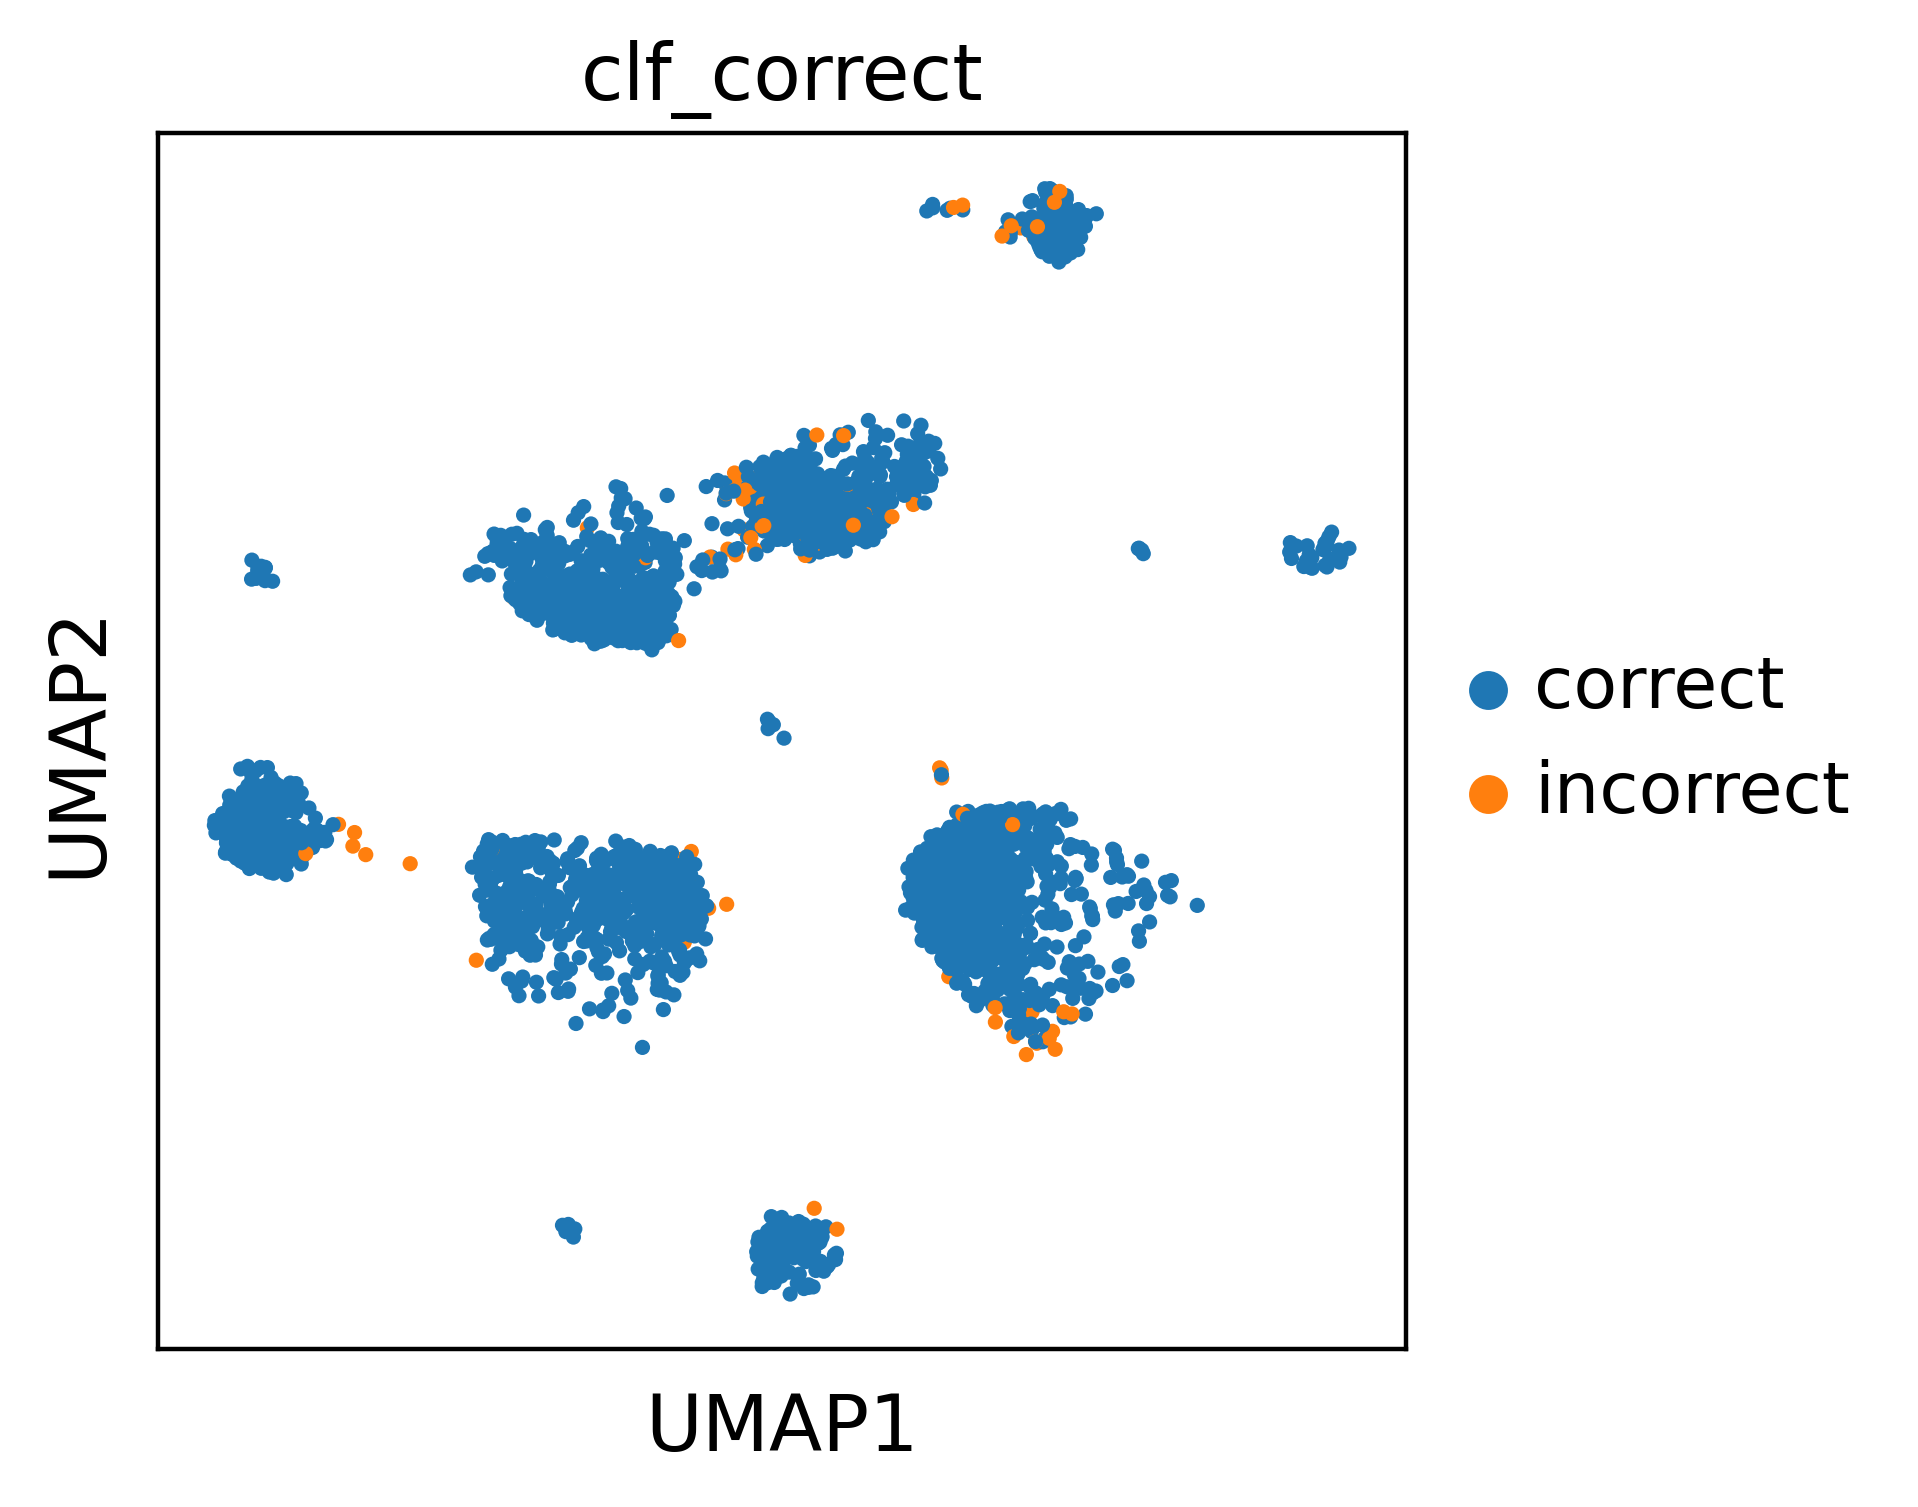

In [38]:
sc.pl.umap(adata_latent[adata_latent.obs.study.isin(query)], color='clf_correct', size=30)

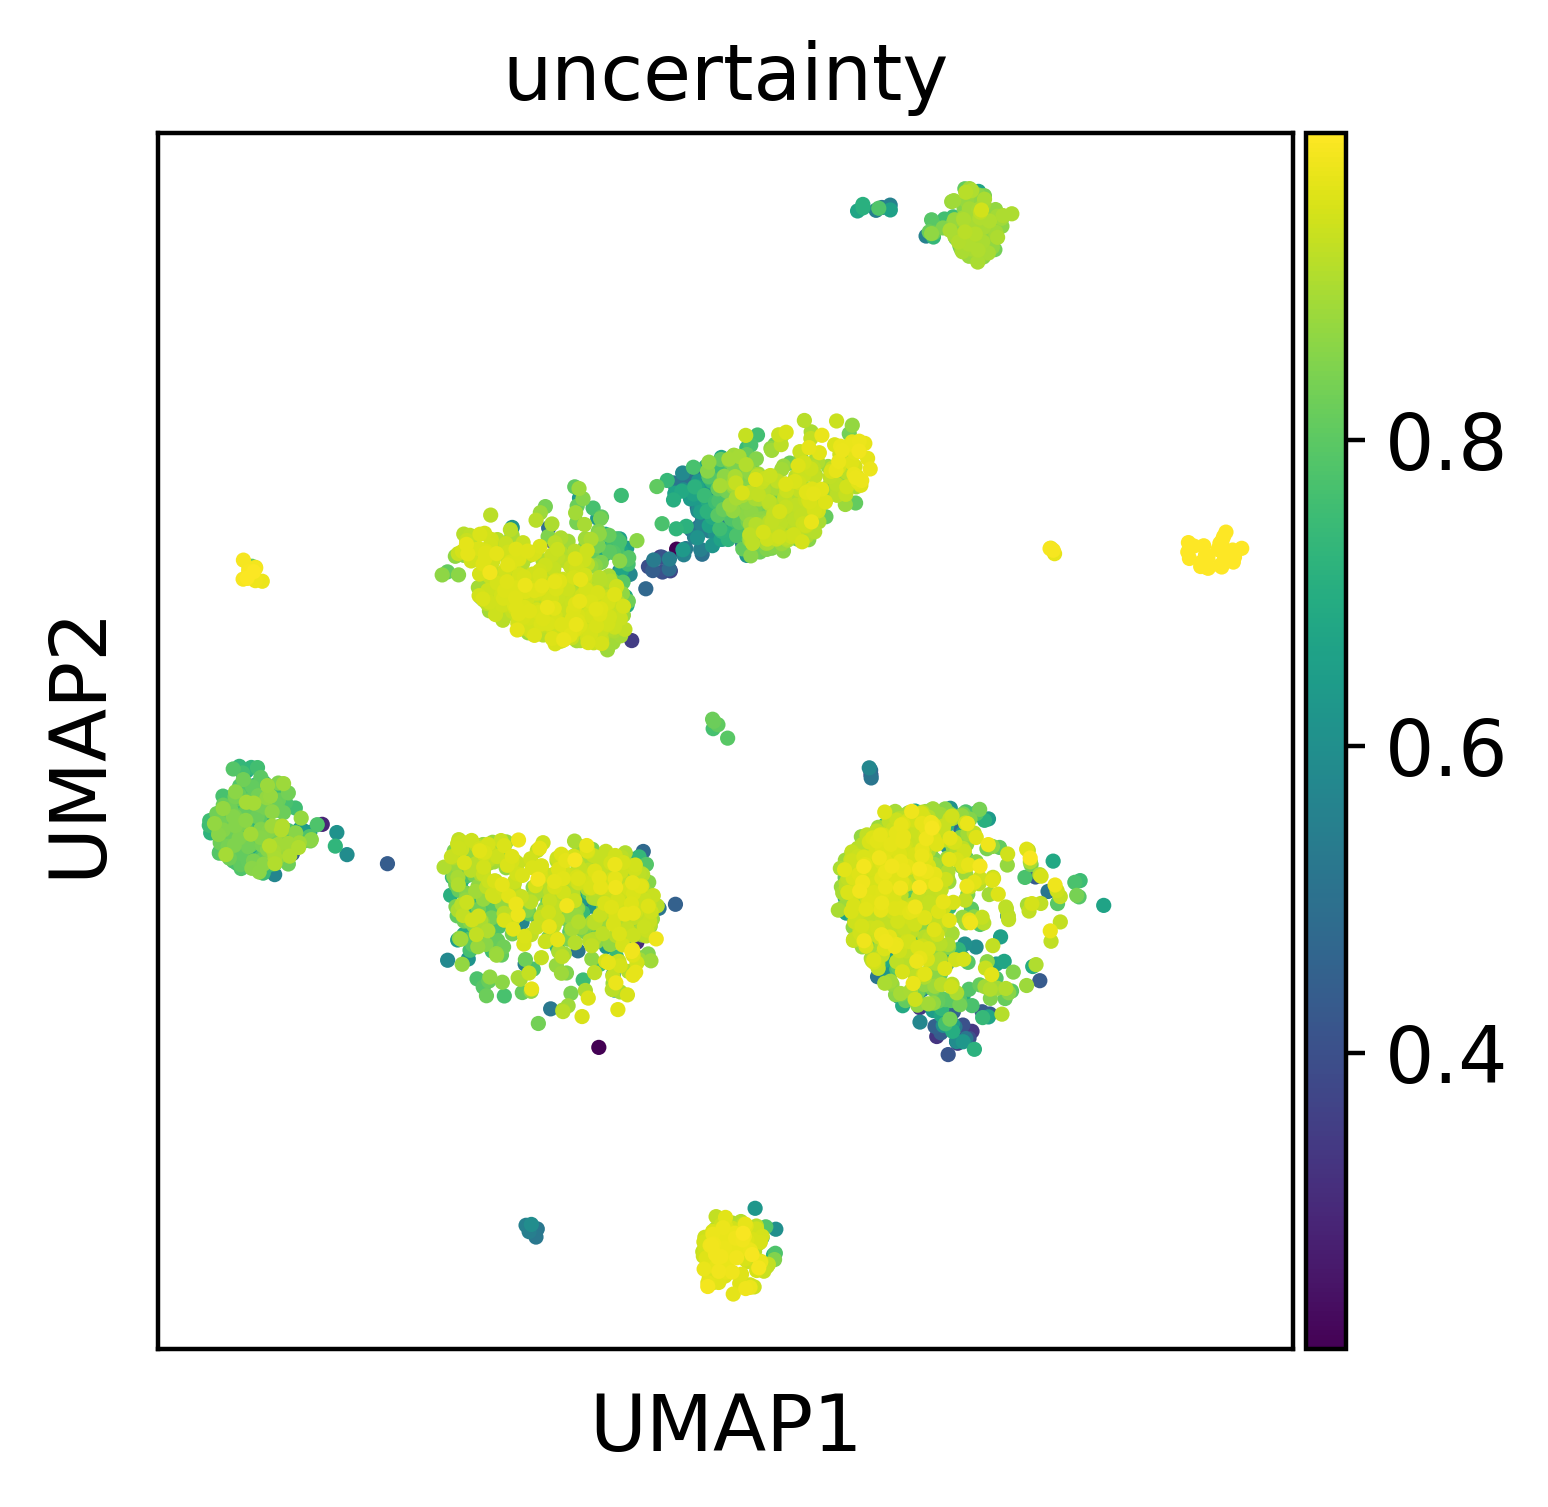

In [39]:
sc.pl.umap(adata_latent[adata_latent.obs.study.isin(query)], color='uncertainty', size=30)